In [1]:
!pip install -qq pandas kagglehub numpy scipy matplotlib scikit-learn ipykernel jupyter pytest
!pip install -qq sentence-transformers seaborn nltk

In [2]:
import kagglehub
import pandas as pd
import os
import numpy as np

In [3]:
# Download latest version
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
df = pd.read_csv(os.path.join(path,"postings.csv"))

### EDA

In [4]:
df.columns

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')

In [5]:
df.shape

(123849, 31)

In [6]:
df["location"].value_counts().head()

location
United States    8125
New York, NY     2756
Chicago, IL      1834
Houston, TX      1762
Dallas, TX       1383
Name: count, dtype: int64

In [7]:
yearly_df = df[df["pay_period"] == "YEARLY"].shape

In [8]:
ny_df = df[df["location"] == "New York, NY"].reset_index()

In [9]:
ny_df["pay_period"].value_counts().head()

pay_period
YEARLY     1201
HOURLY      307
MONTHLY       2
WEEKLY        2
Name: count, dtype: int64

In [10]:
ny_df.shape

(2756, 32)

In [11]:
us_df = df[df["location"] == "United States"]

In [12]:
us_df.shape

(8125, 31)

### Cleaning

In [13]:
[c for c in ny_df.columns if "salary" in c]

['max_salary', 'med_salary', 'min_salary', 'normalized_salary']

In [14]:
ny_df[ny_df["max_salary"].notna()].shape

(1371, 32)

In [15]:
ny_df[ny_df["min_salary"].notna()].shape

(1371, 32)

In [16]:
ny_df[ny_df["med_salary"].notna()].shape

(141, 32)

In [17]:
ny_df[ny_df["max_salary"].notna() & ny_df["min_salary"].notna()].shape

(1371, 32)

#### Drop NaN values and non USD

In [18]:
salary_df = df[df["max_salary"].notna() & df["min_salary"].notna()]

In [19]:
salary_ny_df = ny_df[ny_df["max_salary"].notna() & ny_df["min_salary"].notna()]

#### Annualize Salary

In [20]:
salary_df["pay_period"].value_counts()

pay_period
YEARLY      19107
HOURLY      10212
MONTHLY       288
WEEKLY        177
BIWEEKLY        9
Name: count, dtype: int64

In [21]:
salary_df["max_salary"].describe()

count    2.979300e+04
mean     9.193942e+04
std      7.011101e+05
min      1.000000e+00
25%      4.828000e+01
50%      8.000000e+04
75%      1.400000e+05
max      1.200000e+08
Name: max_salary, dtype: float64

In [22]:
salary_scale = {
    "HOURLY": 2080,
    "WEEKLY": 52,
    "BIWEEKLY": 26,
    "MONTHLY":12
}
for period, scale in salary_scale.items():
    salary_df.loc[salary_df['pay_period'] == period, 'max_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'min_salary'] *= scale
    salary_df.loc[salary_df['pay_period'] == period, 'pay_period'] = "YEARLY"

In [23]:
salary_df["max_salary"].describe()

count    2.979300e+04
mean     2.639483e+05
std      6.096351e+06
min      1.000000e+00
25%      6.572800e+04
50%      1.010000e+05
75%      1.500000e+05
max      5.720000e+08
Name: max_salary, dtype: float64

In [24]:
salary_df["pay_period"].value_counts()

pay_period
YEARLY    29793
Name: count, dtype: int64

In [25]:
salary_df = salary_df[salary_df["currency"] == 'USD']

In [26]:
# salary_df = salary_df[["description","max_salary","min_salary"]]
# salary_df.columns

In [27]:
clean_df = salary_ny_df[["title", "description", "location", "max_salary","min_salary"]]
# clean_df = salary_df[["title", "description", "location", "max_salary","min_salary"]]

# Remove rows where 'titles' or 'description' is NaN or an empty string
clean_df = clean_df[
    (df["title"].notna()) & (df["title"].str.strip() != "") &
    (df["description"].notna()) & (df["description"].str.strip() != "")
]

clean_df.shape

/var/folders/v2/xp28m4jj3z7fyzyg9t6k4vhh0000gn/T/ipykernel_37196/131429457.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  clean_df = clean_df[


(1371, 5)

### Removing outliers

In [28]:
clean_df["max_salary"].describe()

count    1.371000e+03
mean     1.317075e+05
std      1.060676e+05
min      1.600000e+01
25%      7.050000e+04
50%      1.200000e+05
75%      1.850000e+05
max      1.500000e+06
Name: max_salary, dtype: float64

In [29]:
clean_df["min_salary"].describe()

count      1371.000000
mean      94278.108322
std       66456.860146
min          15.000000
25%       60000.000000
50%       90000.000000
75%      133445.425000
max      500000.000000
Name: min_salary, dtype: float64

In [30]:
# Removing outliers based on max_salary
min_salary = 20000

Q1 = clean_df["max_salary"].quantile(0.25)
Q3 = clean_df["max_salary"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = max(Q1 - 1.5 * IQR, min_salary)
upper_bound = Q3 + 1.5 * IQR

clean_df = clean_df[(clean_df["max_salary"] >= lower_bound) & (clean_df["max_salary"] <= upper_bound)]

In [31]:
# Removing outliers based on min_salary

Q1 = clean_df["min_salary"].quantile(0.25)
Q3 = clean_df["min_salary"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = max(Q1 - 1.5 * IQR, min_salary)
upper_bound = Q3 + 1.5 * IQR

clean_df = clean_df[(clean_df["min_salary"] >= lower_bound) & (clean_df["min_salary"] <= upper_bound)]

In [32]:
clean_df.shape

(1087, 5)

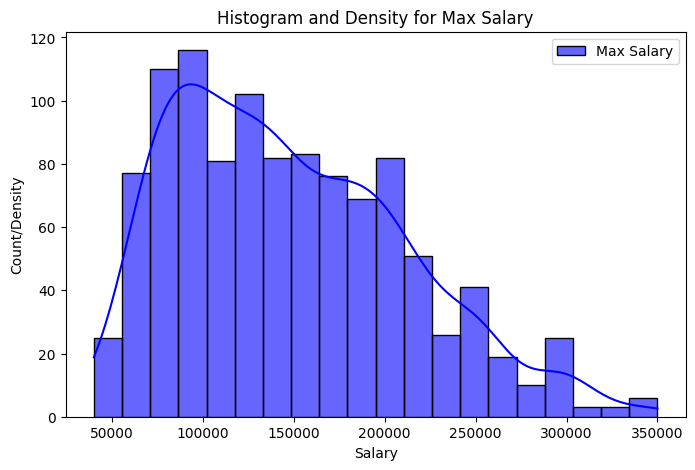

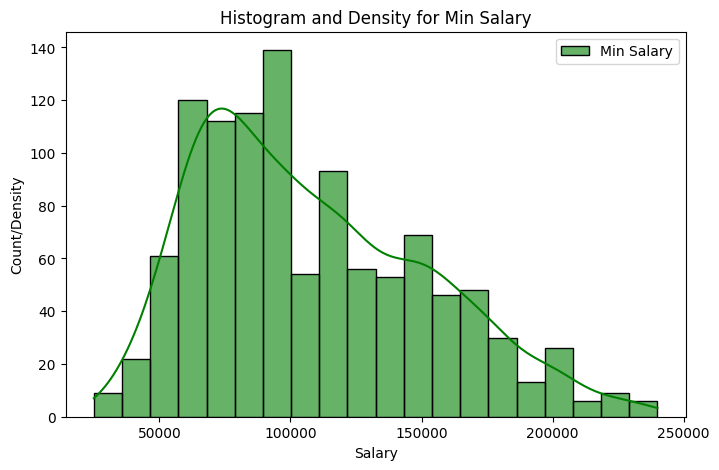

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combined plot for max_salary
plt.figure(figsize=(8, 5))
sns.histplot(clean_df["max_salary"], bins=20, kde=True, color='blue', label="Max Salary", alpha=0.6)
plt.title("Histogram and Density for Max Salary")
plt.xlabel("Salary")
plt.ylabel("Count/Density")
plt.legend()
plt.show()

# Combined plot for min_salary
plt.figure(figsize=(8, 5))
sns.histplot(clean_df["min_salary"], bins=20, kde=True, color='green', label="Min Salary", alpha=0.6)
plt.title("Histogram and Density for Min Salary")
plt.xlabel("Salary")
plt.ylabel("Count/Density")
plt.legend()
plt.show()

In [34]:
clean_df["max_salary"].describe()

count      1087.000000
mean     148288.106339
std       64086.127744
min       40000.000000
25%       95000.000000
50%      139597.000000
75%      191805.000000
max      350000.000000
Name: max_salary, dtype: float64

In [35]:
clean_df["min_salary"].describe()

count      1087.000000
mean     108307.765704
std       43810.403906
min       25000.000000
25%       71850.000000
50%      100000.000000
75%      140000.000000
max      240000.000000
Name: min_salary, dtype: float64

### Rounding target

In [36]:
# n = 5000

# clean_df["min_salary"] = (clean_df["min_salary"] / n).round() * n
# clean_df["max_salary"] = (clean_df["max_salary"] / n).round() * n

# clean_df

### Encoding location

In [37]:
# from sklearn.preprocessing import OneHotEncoder

# unique_locations_count = clean_df["location"].nunique()
# print(unique_locations_count)

# target_mean = clean_df.groupby("location")["min_salary"].mean()
# clean_df["location_encoded"] = clean_df["location"].map(target_mean)

# print(clean_df[["location", "location_encoded"]].head())



# encoder = OneHotEncoder(sparse_output=False)
# location_encoded = encoder.fit_transform(clean_df[["location"]])
# encoded_columns = encoder.get_feature_names_out(["location"])

# location_encoded_df = pd.DataFrame(location_encoded, columns=encoded_columns)
# clean_df = pd.concat([clean_df.reset_index(drop=True), location_encoded_df], axis=1)
# clean_df = clean_df.drop(columns=["location"])


### Data Embedding

In [38]:
from embedding_models import sbert_embedding, bag_of_words_with_laplace, bag_of_words

In [39]:
titles = list(clean_df["title"])
descriptions = list(clean_df["description"])
locations = list(clean_df["location"])

combined_text = [
    f"Job title: {titles[i]}\nJob description:{descriptions[i]}\nLocation: {locations[i]}" for i in range(len(titles))
]

In [40]:
# title_embedding = sbert_embedding(titles)
# description_embedding = sbert_embedding(descriptions)
# location_embedding = sbert_embedding(locations)

# title_embedding = np.array(title_embedding)
# description_embedding = np.array(description_embedding)
# location_embedding = np.array(location_embedding)


combined_embedding = np.array(
    sbert_embedding(combined_text)
)

combined_embedding.shape

(1087, 384)

In [41]:
# title_embedding.shape

In [42]:
# description_embedding.shape

In [43]:
# location_embedding.shape

In [44]:
# title_embedding_df = pd.DataFrame(title_embedding, 
#                                   columns=[f"title_embedding_{i}" for i in range(title_embedding.shape[1])])

# description_embedding_df = pd.DataFrame(description_embedding, 
#                                         columns=[f"description_embedding_{i}" for i in range(description_embedding.shape[1])])

# location_embedding_df = pd.DataFrame(location_embedding, 
#                                         columns=[f"location_embedding_{i}" for i in range(location_embedding.shape[1])])

# clean_df = pd.concat([title_embedding_df.reset_index(drop=True), 
#                       description_embedding_df.reset_index(drop=True),
#                       location_embedding_df.reset_index(drop=True),
#                       clean_df.reset_index(drop=True)], axis=1)

In [45]:
combined_embedding_df = pd.DataFrame(combined_embedding, 
                                        columns=[f"embedding_{i}" for i in range(combined_embedding.shape[1])])

clean_df = pd.concat([combined_embedding_df.reset_index(drop=True), 
                      clean_df.reset_index(drop=True)], axis=1)

In [46]:
clean_df = clean_df.drop(columns=["title", "description", "location"])
clean_df.columns

Index(['embedding_0', 'embedding_1', 'embedding_2', 'embedding_3',
       'embedding_4', 'embedding_5', 'embedding_6', 'embedding_7',
       'embedding_8', 'embedding_9',
       ...
       'embedding_376', 'embedding_377', 'embedding_378', 'embedding_379',
       'embedding_380', 'embedding_381', 'embedding_382', 'embedding_383',
       'max_salary', 'min_salary'],
      dtype='object', length=386)

### Final & cleaned dataset

In [47]:
clean_df.to_csv("sbern_2_clean_data.csv", index=False)

#### PCA reduced

In [48]:
from sklearn.decomposition import PCA

X = clean_df.drop(columns=["max_salary", "min_salary"])

In [49]:
# Normalizing
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(X).toarray()


In [50]:
pca = PCA(n_components=0.95)  # Retain 80% of the cumulative variance

X_pca = pca.fit_transform(X)

reduction_percentage = ((X.shape[1] - pca.n_components_) / X.shape[1]) * 100


print("Original shape:", X.shape)
print("Reduced shape:", X_pca.shape)
print(f"Number of components selected: {pca.n_components_} out of {X.shape[1]}")
print(f"Reduced by: {reduction_percentage:.2f}%")

Original shape: (1087, 384)
Reduced shape: (1087, 183)
Number of components selected: 183 out of 384
Reduced by: 52.34%


In [51]:
X_pca_df = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
clean_pca_df = pd.concat([X_pca_df, clean_df[["max_salary", "min_salary"]].reset_index(drop=True)], axis=1)

In [52]:
clean_pca_df.to_csv("sbern_2_clean_data_PCA.csv", index=False)